<h1>NetworkX Demo</h1>

In [101]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
basedir = '../'
sys.path.append(basedir)

import numpy as np
import pandas as pd
import networkx as nx
import pylab as plt
import csv

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patches as mpatches

from IPython.display import display
from lda_for_fragments import Ms2Lda

# get rid of annoying warnings
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h2>1. Load Data and apply thresholding</h2>

Load Beer3pos project used by Justin and apply thresholding below.

In [102]:
ms2lda = Ms2Lda.resume_from('results/Manuscript_Beer3POSmode_EFassignerALL.project')

Project loaded from results/Manuscript_Beer3POSmode_EFassignerALL.project time taken = 20.8399140835
 - input_filenames = 
	../input/manuscript/Beer3pos_MS1filter_Method3_fragments.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_losses.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_ms1.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_ms2.csv
 - df.shape = (1422, 4496)
 - K = 300
 - alpha = 0.166666666667
 - beta = 0.1
 - number of samples stored = 1
 - last_saved_timestamp = 11/11/15 23:39:09
 - message = Beer3Pos analysis for the manuscript with EFassigner EF assignments for ms1, fragments, and losses


In [103]:
ms2lda.do_thresholding(th_doc_topic=0.05, th_topic_word=0.01)

<h2>2. Create network graph</h2>

A function to extract a networkx graph containing only the motifs we're interested in

In [104]:
def get_motif_graph(ms2lda, motifs_of_interest):

    G, json_data = ms2lda.get_network_graph(to_highlight=None, degree_filter=0)
    motifs_of_interest = ['motif_' + str(id) for id in motifs_of_interest]

    # 1. keep only the motifs in the list
    remove_count = 0
    nodes = G.nodes(data=True)
    for node_id, node_data in nodes:
        # 1 for doc, 2 for motif
        if node_data['group'] == 2 and node_data['name'] not in motifs_of_interest: 
            remove_count += 1
            G.remove_node(node_id)
    print "Removed %d motifs from the graph because they're not in the list" % remove_count

    # 2. keep only motifs having shared nodes with other motifs
    removed_motifs = []
    nodes = G.nodes(data=True)    
    for node_id, node_data in nodes:
        if node_data['group'] == 2:
            # check if any doc in this motif is shared with another motif (degree > 1)
            neighbours = G.neighbors(node_id)
            share = False
            for nb in neighbours:
                deg = G.degree(nb)
                if deg > 1:
                    share = True
            # if not then delete from the graph too
            if not share:
                removed_motifs.append(node_data['name'])
                G.remove_node(node_id)
    print "Removed %s from the graph because they don't share documents with other motifs in the list" % removed_motifs
    
    # 3. delete all unconnected nodes from the graph
    unconnected = []
    nodes = G.nodes(data=True)    
    for node_id, node_data in nodes:
        if G.degree(node_id) == 0:
            unconnected.append(node_id)
    G.remove_nodes_from(unconnected)   
    print "Removed %d unconnected documents from the graph" % len(unconnected)
                    
    return G

Specify the list of motifs of interest below. 

In [105]:
# all the highest-confidence motifs
# motifs_of_interest = [260, 262, 226, 158, 243, 127, 174, 59, 214, 60, 151, 40, 284, 276, 45, 
#                       79, 184, 130, 220, 55, 241, 13, 115, 162, 19, 58, 202, 131, 129, 
#                       222, 230, 67, 42, 116]

# smaller list
motifs_of_interest = [262, 158, 220, 55, 241, 115, 202, 226, 22]

In [106]:
# get the network graph
G = get_motif_graph(ms2lda, motifs_of_interest)

# display a general graph info
print "\n" + nx.info(G)

Removed 291 motifs from the graph because they're not in the list
Removed ['motif_22', 'motif_226'] from the graph because they don't share documents with other motifs in the list
Removed 1176 unconnected documents from the graph

Name: 
Type: Graph
Number of nodes: 253
Number of edges: 275
Average degree:   2.1739


So, when we create the graph *G*, we also filtered it in such a way that (1) only the motifs in the provided list are retained and additionally, (2) these motifs must have some documents shared with another motif.

<h2>3. Plot bipartite</h2>

A function to plot the bipartite graph of the MS1 peaks that are connected to at least *min_degree* number of Mass2Motifs.

In [107]:
def plot_bipartite(G, min_degree, fig_width=10, fig_height=20, spacing_left=1, spacing_right=2):
        
    # extract subgraph of docs connected to at least min_degree motifs
    doc_nodes_to_keep = set()
    motif_nodes_to_keep = set()    
    nodes = G.nodes(data=True)    
    for node_id, node_data in nodes:
        # group == 1 is a doc, 2 is a motif
        if node_data['group'] == 1 and G.degree(node_id) >= min_degree:
            neighbours = G.neighbors(node_id)
            doc_nodes_to_keep.add(node_id)
            motif_nodes_to_keep.update(neighbours)
    to_keep = doc_nodes_to_keep | motif_nodes_to_keep # set union
    SG = G.subgraph(to_keep)

    # make bipartite layout, put doc nodes on left, motif nodes on right
    pos = dict()
    pos.update( (n, (1, i*spacing_left)) for i, n in enumerate(doc_nodes_to_keep) )
    pos.update( (n, (2, i*spacing_right)) for i, n in enumerate(motif_nodes_to_keep) )

    # for labelling purpose
    motif_singleton = {}
    for n in motif_nodes_to_keep:
        children = G.neighbors(n) # get the children of this motif
        degree_dict = G.degree(nbunch=children) # get the degrees of children
        # count how many children have degree == 1
        children_degrees = [degree_dict[c] for c in degree_dict]
        count_singleton = sum(child_deg == 1 for child_deg in children_degrees)        
        motif_singleton[n] = count_singleton
        
    # set the node and edge labels
    doc_labels = {}
    motif_labels = {}
    doc_motifs = {} # used for the fragmentation spectra plot
    all_motifs = set()
    for node_id, node_data in SG.nodes(data=True):
        if node_data['group'] == 2: # is a motif
            motif_labels[node_id] = "%s (+%d)" % (node_data['name'], motif_singleton[node_id])
        elif node_data['group'] == 1: # is a doc
            pid = int(node_data['peakid'])
            doc_labels[node_id] = 'pid_%d' % pid
            parent_motifs = set()
            for neighbour_id in SG.neighbors(node_id):
                motif_name = SG.node[neighbour_id]['name']
                _, motif_id = motif_name.split('_')
                parent_motifs.add(int(motif_id))
            doc_motifs[pid] = parent_motifs
            all_motifs.update(parent_motifs)
            
    # plot the bipartite graph
    plt.figure(figsize=(fig_width, fig_height))
    plt.axis('off')
    fig = plt.figure(1)
    nx.draw_networkx_nodes(SG, pos, alpha=0.25)
    nx.draw_networkx_edges(SG, pos, alpha=0.25)
    _ = nx.draw_networkx_labels(SG, pos, doc_labels, font_size=10)
    _ = nx.draw_networkx_labels(SG, pos, motif_labels, font_size=16)
    ymax = max(len(doc_labels)*spacing_left, len(motif_labels)*spacing_right)
    _ = plt.ylim([-1, ymax])
    _ = plt.title('MS1 peaks connected to at least %d motifs' % min_degree)
    
    return doc_nodes_to_keep, doc_motifs, all_motifs

In the plot below, we draw a bipartite graph where the left side is the MS1 peaks (labelled by their peak ids) and the right side are the M2Ms. The graph has been filtered such that we only show MS1 peaks that are connected to at least *min_degree* number of Mass2Motifs. 

The number beside each motif (e.g. +25) shows how many other MS1 connected to it that we are not showing because there's no overlap with other motifs in the list.

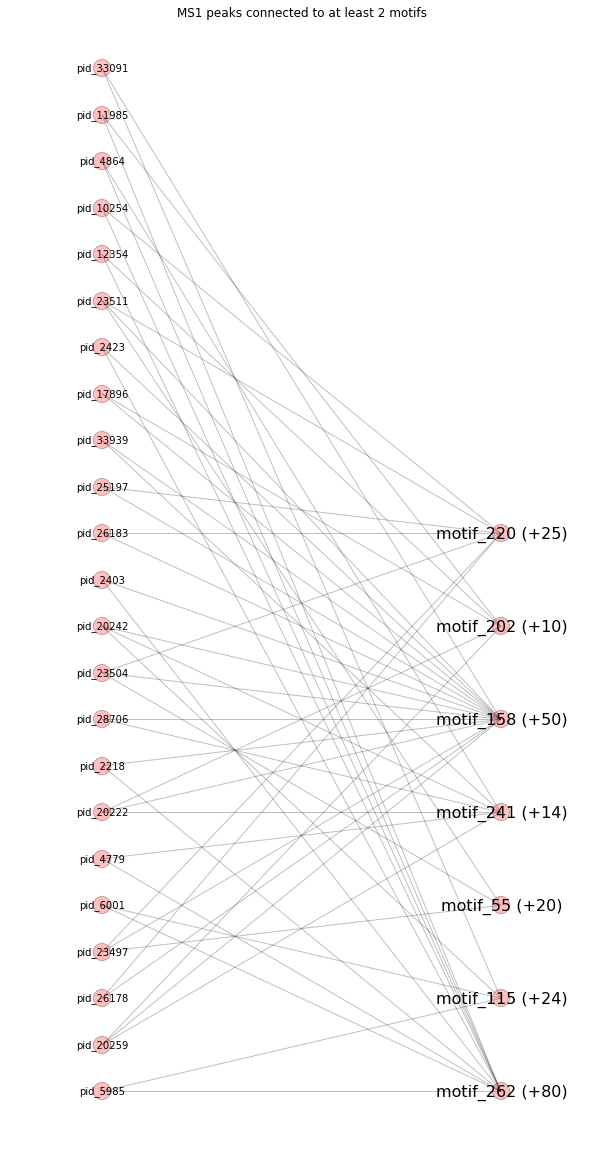

In [108]:
doc_nodes, doc_motifs, all_motifs = plot_bipartite(G, min_degree=2, fig_width=10, fig_height=20, spacing_left=1, spacing_right=2)

# can tweak the fig_ and spacing_ parameters to adjust the plot appearance, especially if graph is dense
# doc_nodes, doc_motifs, all_motifs = plot_bipartite(G, min_degree=3, fig_width=10, fig_height=20, spacing_left=1, spacing_right=2)

We can also plot the fragmentation spectra of these MS1 peaks of interest, coloring their MS2 peaks by the motifs.

Some functions to make plots etc.

In [109]:
# find out which words belong to which topics
word_map = ms2lda.print_motif_features(selected_motifs=motifs_of_interest, quiet=True)

# and also read the annotation assigned to each Mass2Motif from a CSV file for the report
motif_annotation = {}
for item in csv.reader(open("results/beer3pos_annotation.csv"), skipinitialspace=True):
    key = int(item[0])
    val = item[1]
    motif_annotation[key] = val

i = 0
motif_idx = {}
for key in all_motifs:
    motif_idx[key] = i
    i += 1
    
# map each motif to the colourmap too
norm = mpl.colors.Normalize(vmin=0, vmax=i)
cmap = cm.hsv
motif_colour = cm.ScalarMappable(norm=norm, cmap=cmap)

# used for the fragmentation spectra plot
doc_motifs_all = {}
for node_id, node_data in G.nodes(data=True):
    if node_data['group'] == 1: # is a doc
        pid = int(node_data['peakid'])
        parent_motifs = set()
        for neighbour_id in G.neighbors(node_id):
            motif_name = G.node[neighbour_id]['name']
            _, motif_id = motif_name.split('_')
            parent_motifs.add(int(motif_id))
        doc_motifs_all[pid] = parent_motifs

In [110]:
def get_word_motif(word, doc_motifs):
    word_motif = None
    if word in word_map:
        to_check = word_map[word]
        same_motifs = list(to_check.intersection(doc_motifs))
        if len(same_motifs) > 0:
            word_motif = same_motifs[0]
    return word_motif

In [111]:
def plot_fragmentation_spectrum(df, save_to=None):
    
    # make sure that the fragment and loss words got plotted first
    df.sort_values(['fragment_motif', 'loss_motif'], ascending=True, inplace=True, na_position='last')
    
    plt.figure(figsize=(20, 10), dpi=300)
    ax = plt.subplot(111)
    font_size = 24
    
    for row_index, row in df.iterrows():
        
        mz = row['ms2_mz']
        intensity = row['ms2_intensity']    
        frag_m2m = row['fragment_motif']
        loss_m2m = row['loss_motif']
        
        word_colour = 'lightgray'
        if not np.isnan(loss_m2m):
            word_colour = motif_colour.to_rgba(motif_idx[loss_m2m])            
        if not np.isnan(frag_m2m):
            word_colour = motif_colour.to_rgba(motif_idx[frag_m2m])

        plt.plot((mz, mz), (0, intensity), linewidth=5.0, color=word_colour)

    plt.xlabel('m/z')
    plt.ylabel('Relative Intensity')

    fragment_m2m = df['fragment_motif'].values
    fragment_m2m = set(fragment_m2m[~np.isnan(fragment_m2m)].tolist())

    loss_m2m = df['loss_motif'].values
    loss_m2m = set(loss_m2m[~np.isnan(loss_m2m)].tolist())
    
    m2m_used = fragment_m2m | loss_m2m
    m2m_patches = []
    for m2m in m2m_used:
        m2m_colour = motif_colour.to_rgba(motif_idx[m2m])
        m2m_patch = mpatches.Patch(color=m2m_colour, label='M2M_%d' % m2m)
        m2m_patches.append(m2m_patch)
    ax.legend(handles=m2m_patches, loc='upper center', bbox_to_anchor=(0.5, 1.05),
              ncol=3, fancybox=True, shadow=True, prop={'size': font_size})        

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(font_size)    
    
    if save_to is not None:
        print "Figure saved to %s" % save_to
        plt.savefig(save_to, bbox_inches='tight')
    plt.show()

In [112]:
def print_report(G, peak_id, doc_motifs, show_df=False, save_to=None):
    
    # get the ms1 info
    ms1_rows = ms2lda.ms1.loc[ms2lda.ms1['peakID'] == peak_id]
    first_row = ms1_rows.head(1)
    ms1_mz = first_row['mz'].values[0]
    ms1_rt = first_row['rt'].values[0]
    ms1_intensity = first_row['intensity'].values[0]
    ms1_annotation = first_row['annotation'].values[0]
    ms1_motifs = doc_motifs[peak_id]
    degree = G.degree(node_id)
    print "MS1 peakID %d mz %.4f rt %.2f intensity %.2f (%s) degree %d" % (peak_id, ms1_mz, ms1_rt, ms1_intensity, ms1_annotation, degree)
    for m2m in ms1_motifs:
        try:
            m2m_annot = motif_annotation[m2m]
        except KeyError:
            m2m_annot = '?'
        print " - M2M_%s\t: %s" % (m2m, m2m_annot)
    print

    # get the ms2 info
    ms2_rows = ms2lda.ms2.loc[ms2lda.ms2['MSnParentPeakID'] == peak_id]
    ms2_mz = ms2_rows['mz'].values
    ms2_intensity = ms2_rows['intensity'].values
    ms2_fragment_words = ms2_rows['fragment_bin_id'].values
    ms2_loss_words = ms2_rows['loss_bin_id'].values
    ms2_annotation = ms2_rows['annotation'].values

    document = []
    for w in range(len(ms2_mz)):
        mz = ms2_mz[w]
        intensity = ms2_intensity[w]
        if not np.isnan(float(ms2_fragment_words[w])):
            fragment_word = 'fragment_' + ms2_fragment_words[w]
            fragment_motif = get_word_motif(fragment_word, ms1_motifs)
        else:
            fragment_word = np.NaN
            fragment_motif = np.NaN
        if not np.isnan(float(ms2_loss_words[w])):
            loss_word = 'loss_' + ms2_loss_words[w]
            loss_motif = get_word_motif(loss_word, ms1_motifs)        
        else:
            loss_word = np.NaN
            loss_motif = np.NaN
        annot = ms2_annotation[w]
        item = (mz, intensity, fragment_word, fragment_motif, loss_word, loss_motif, annot)
        # print "%08.4f   %.2f    %-20s %-5s %-15s %-5s" % item
        document.append(item)

    df = pd.DataFrame(document, columns=['ms2_mz', 'ms2_intensity', 'fragment_word', 'fragment_motif', 'loss_word', 'loss_motif', 'ef'])
    if show_df:
        display(df)
        print
    plot_fragmentation_spectrum(df, save_to)

In [113]:
def get_peak_ids_of_m2m(G, m2m):
                             
    for node_id, node_data in G.nodes(data=True):

        if node_data['group'] == 2: # is a motif

            motif_name = G.node[node_id]['name']
            _, motif_id = motif_name.split('_')
            motif_id = int(motif_id)
        
            if motif_id == m2m:
                children = G.neighbors(node_id) # get the children of this motif
                children_pids = [int(G.node[c]['peakid']) for c in children]
                return set(children_pids)
                                     
    return None

<h2>4. Example</h2>

Now we have everything we need to produce some nice plots! Here are some examples. First, I print the fragmentation spectra of MS1 with peak ID = 20259 and 28706. i selected these two fragmentation spectra from the list of all plots (in section 5) because they seem to show the strength of the LDA approach well.

Note: sometimes in the plot, the same MS2 peak generates a fragment word described by one topic in one colour and a loss word described by another topic in a different colour. In this case, the fragment word colour will win.

MS1 peakID 20259 mz 277.1585 rt 427.10 intensity 1081880.00 (C12H25O3N2S) degree 1
 - M2M_241	: Histidine substructure
 - M2M_202	: Tryptophan related substructure
 - M2M_158	: Leucine related substructure



,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,110.071663,1.000000,fragment_110.07176,241,loss_167.08599,241,"C5H8N3,loss_C9H14NP"
1,86.096443,0.786891,fragment_86.09652,158,loss_191.06155,241,"C5H12N,loss_C7H13O3NS"
2,83.060303,0.245350,fragment_83.06041,241,loss_194.09798,NaN,"C4H7N2,loss_C8H18O3S"
3,259.136200,0.187194,fragment_259.13595,NaN,NaN,NaN,NaN
4,93.044960,0.182310,fragment_93.04509,241,NaN,NaN,C5H5N2
5,188.070389,0.155427,fragment_188.07061,202,NaN,NaN,C11H10O2N
6,118.065384,0.153206,fragment_118.06544,202,NaN,NaN,C8H8N
7,231.143066,0.114169,fragment_231.1431,NaN,NaN,NaN,NaN
8,91.053848,0.111245,fragment_91.05413,202,NaN,NaN,C7H7
9,143.117538,0.111168,fragment_143.11757,241,NaN,NaN,C7H15ON2



Figure saved to results/example.png


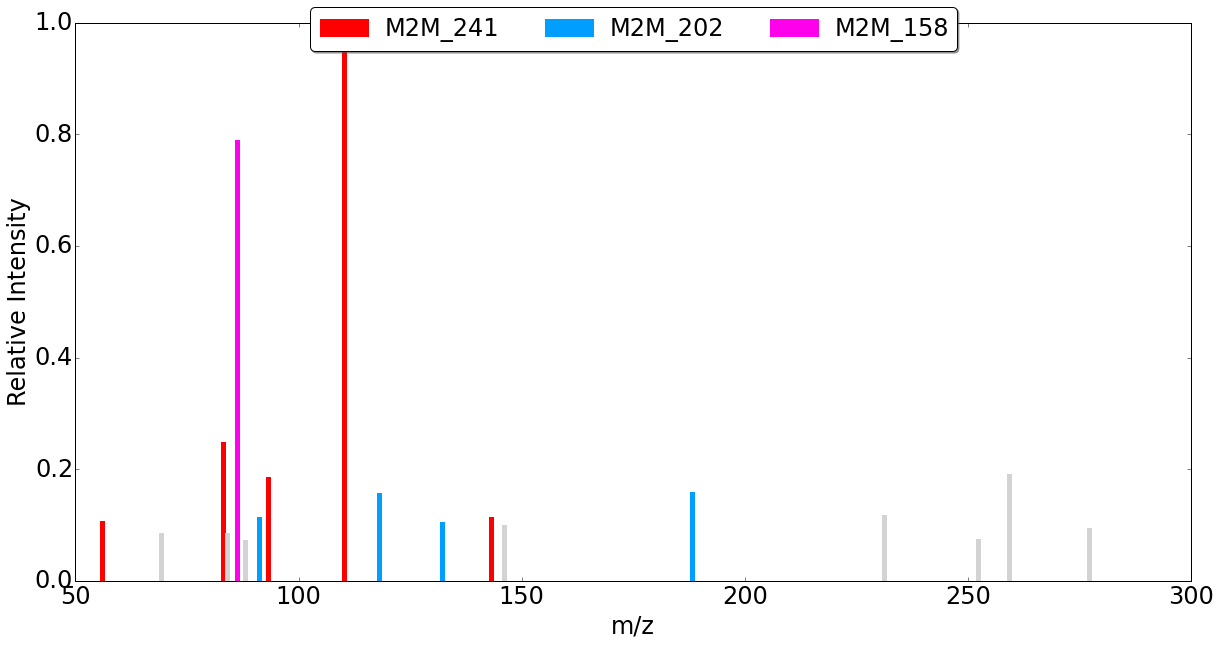

In [114]:
# remove the save_to parameter if you don't want to save to file
# remove the show_df parameter if you don't want to see the tabular output
print_report(G, 20259, doc_motifs, show_df=True, save_to='results/example.png')

MS1 peakID 28706 mz 362.2166 rt 503.15 intensity 643910.00 (C21H34NP2) degree 1
 - M2M_241	: Histidine substructure
 - M2M_158	: Leucine related substructure



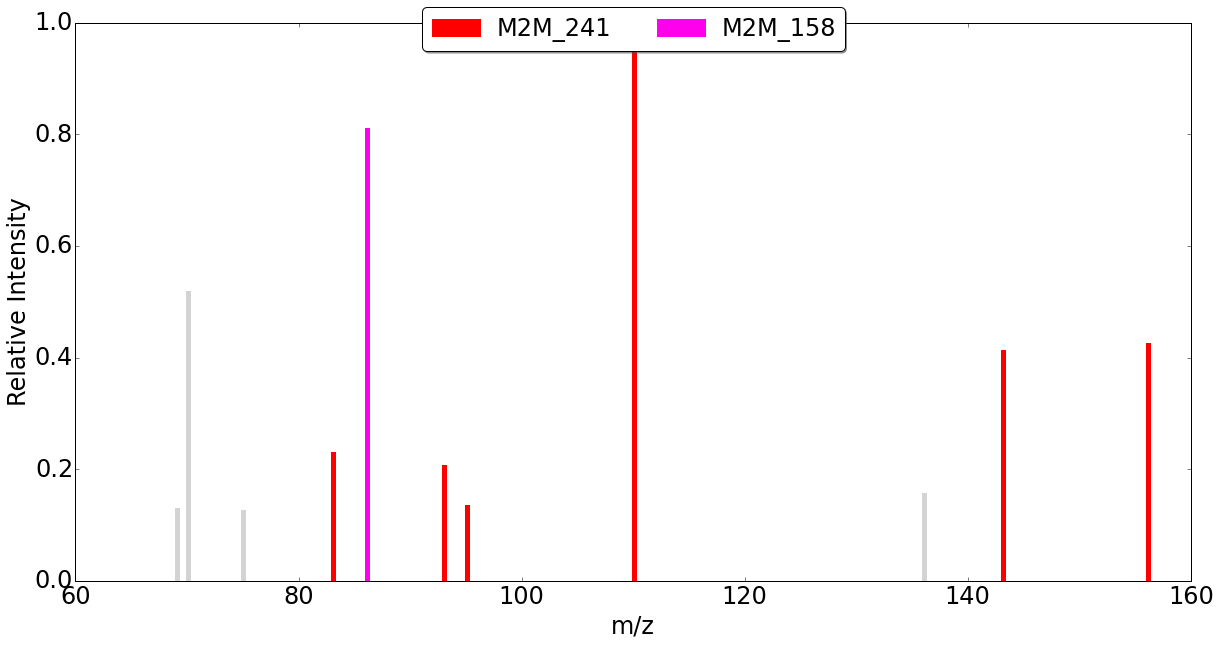

In [115]:
print_report(G, 28706, doc_motifs)

We also want to show other fragmentation spectra from M2M 241 for comparison. To do this, we need to get the peak IDS of all the MS1 peaks connected to this motif.

set([4864, 449, 28706, 20259, 14469, 4839, 24713, 4779, 14514, 28718, 14424, 20242, 33939, 9236, 29110, 25207, 19224, 33172, 16731, 9533, 20222])

MS1 peakID 24713 mz 310.2125 rt 240.35 intensity 1472855.38 (C16H28O3N3) degree 1
 - M2M_241	: Histidine substructure



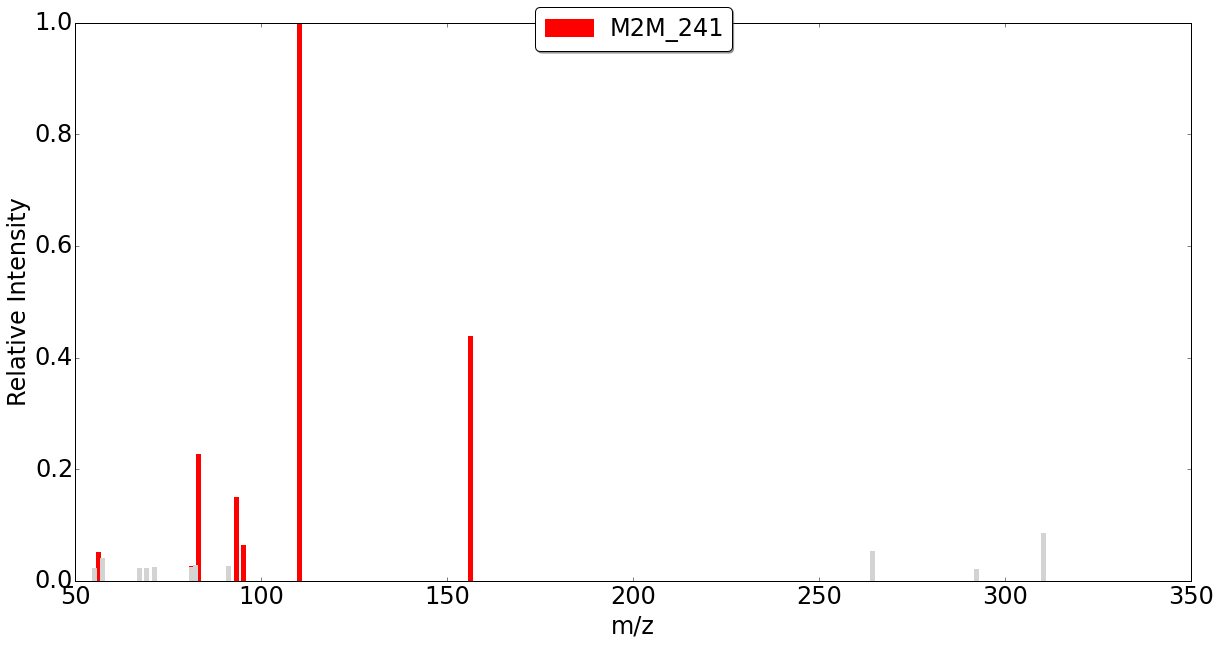

MS1 peakID 16731 mz 251.1499 rt 409.09 intensity 2320696.00 (C12H27OS2) degree 1
 - M2M_241	: Histidine substructure



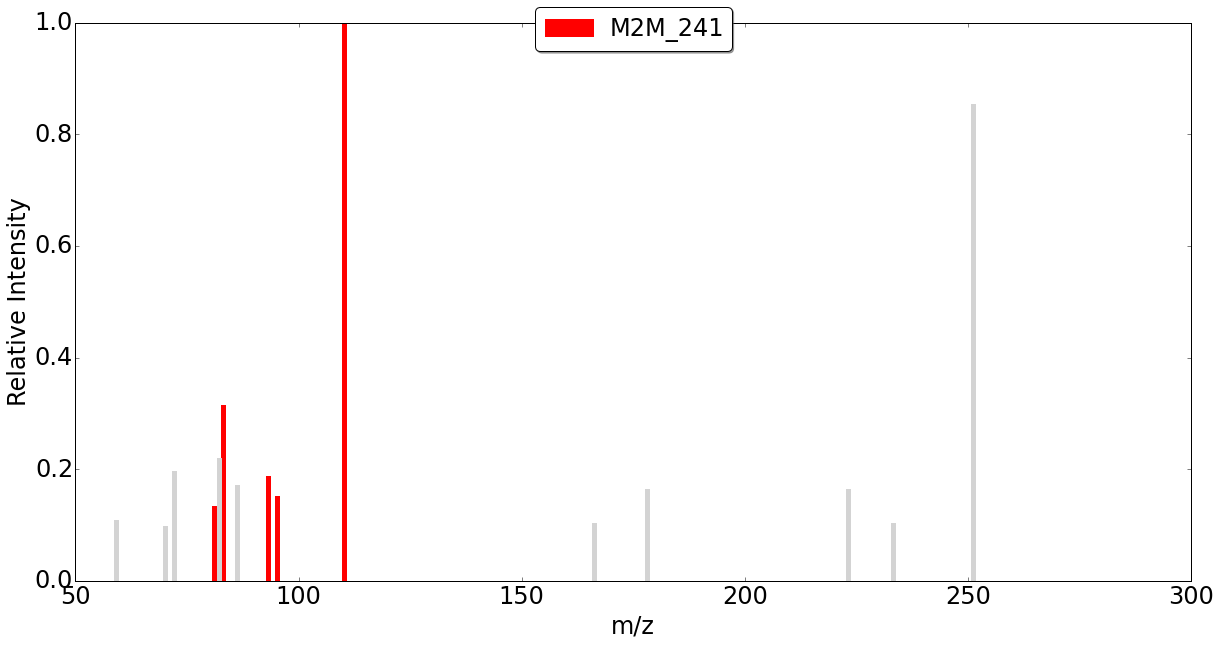

In [116]:
print get_peak_ids_of_m2m(G, 241)
print

print_report(G, 24713, doc_motifs_all)
print_report(G, 16731, doc_motifs_all)

And some examples for M2M 202.

set([12354, 20259, 8772, 17896, 10474, 8336, 11985, 10706, 30163, 22068, 20222, 3513, 26266, 10364, 14846])

MS1 peakID 8336 mz 188.0706 rt 553.53 intensity 13060257.00 (C11H10O2N) degree 1
 - M2M_202	: Tryptophan related substructure



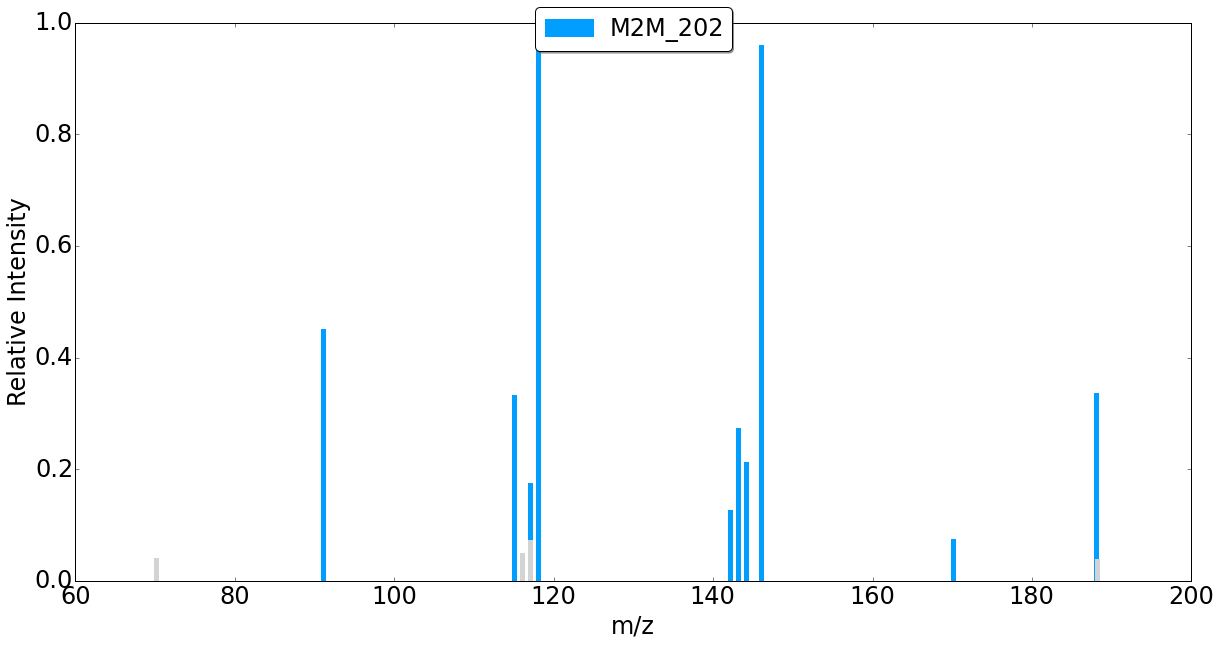

MS1 peakID 26266 mz 334.1398 rt 541.00 intensity 1385774.88 (C18H25ONPS) degree 1
 - M2M_202	: Tryptophan related substructure



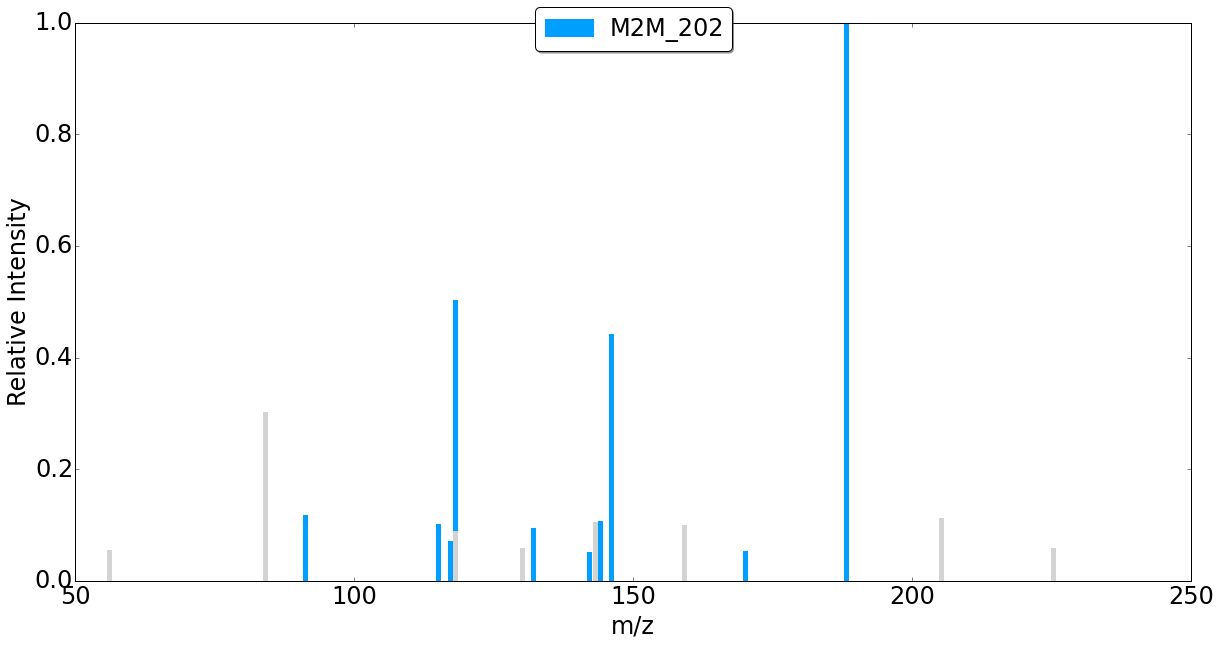

In [117]:
print get_peak_ids_of_m2m(G, 202)
print

print_report(G, 8336, doc_motifs_all)
print_report(G, 26266, doc_motifs_all)

<h2>5. More Examples</h2>

Use the following to find the intersection of the documents shared by any topics.

In [118]:
peak_ids1 = get_peak_ids_of_m2m(G, 115)
peak_ids2 = get_peak_ids_of_m2m(G, 262)
overlap = peak_ids1.intersection(peak_ids2)

print overlap

set([5985, 6001])


The following plots all the MS1 nodes of interest (degree > min_degree) in the bipartite graph

MS1 peakID 5985 mz 166.0863 rt 377.30 intensity 880995.75 (C9H12O2N) degree 2
 - M2M_115	: [phenylalanine-COOH] based substructure
 - M2M_262	: Carboxylic acid group (COOH) - generic substructure in amino acids and organic acids



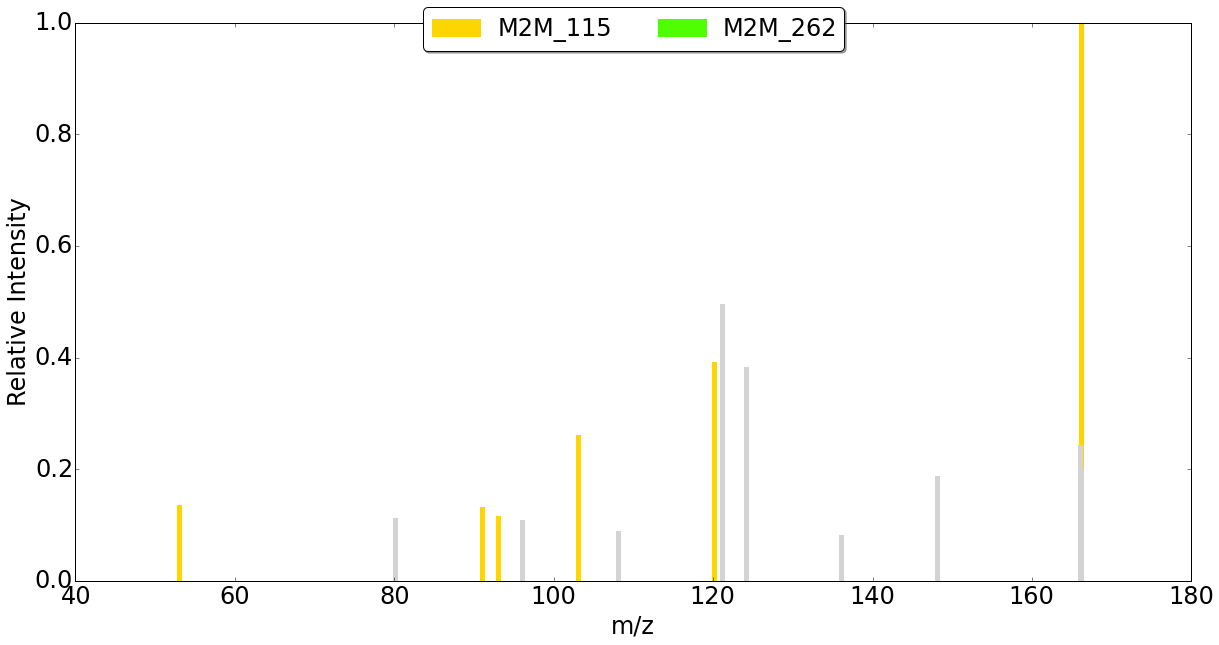

MS1 peakID 20259 mz 277.1585 rt 427.10 intensity 1081880.00 (C12H25O3N2S) degree 3
 - M2M_241	: Histidine substructure
 - M2M_202	: Tryptophan related substructure
 - M2M_158	: Leucine related substructure



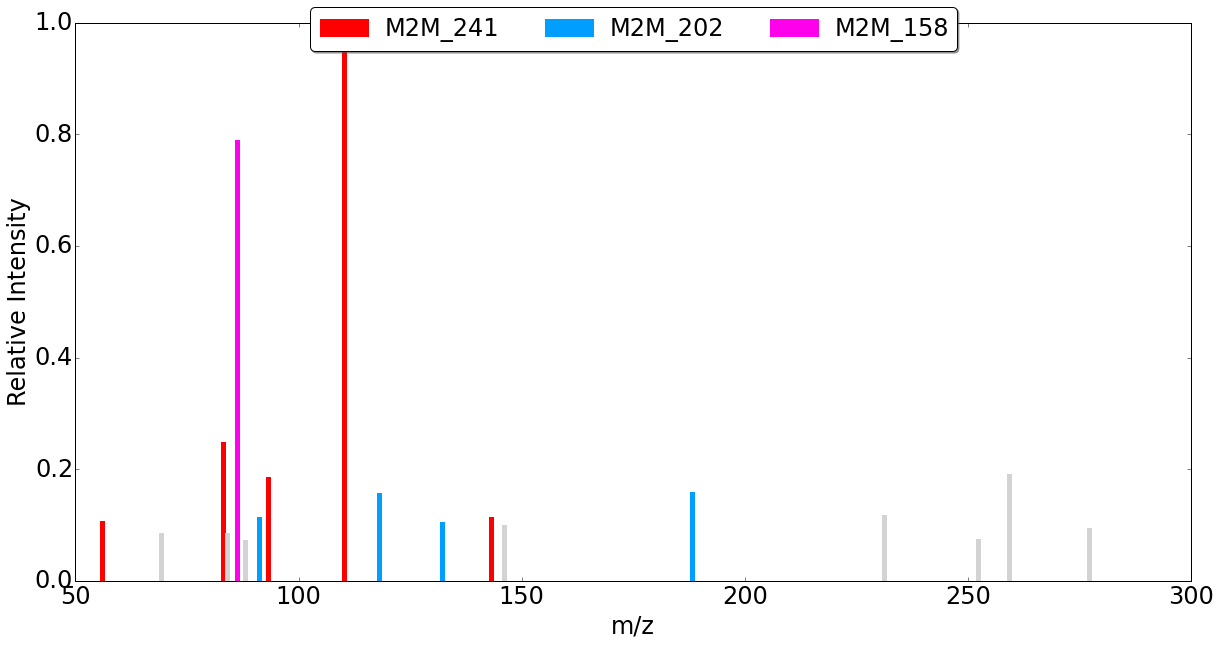

MS1 peakID 26178 mz 332.1106 rt 462.11 intensity 1729951.00 (C13H22O3N3S2) degree 2
 - M2M_220	: Adenine substructure
 - M2M_158	: Leucine related substructure



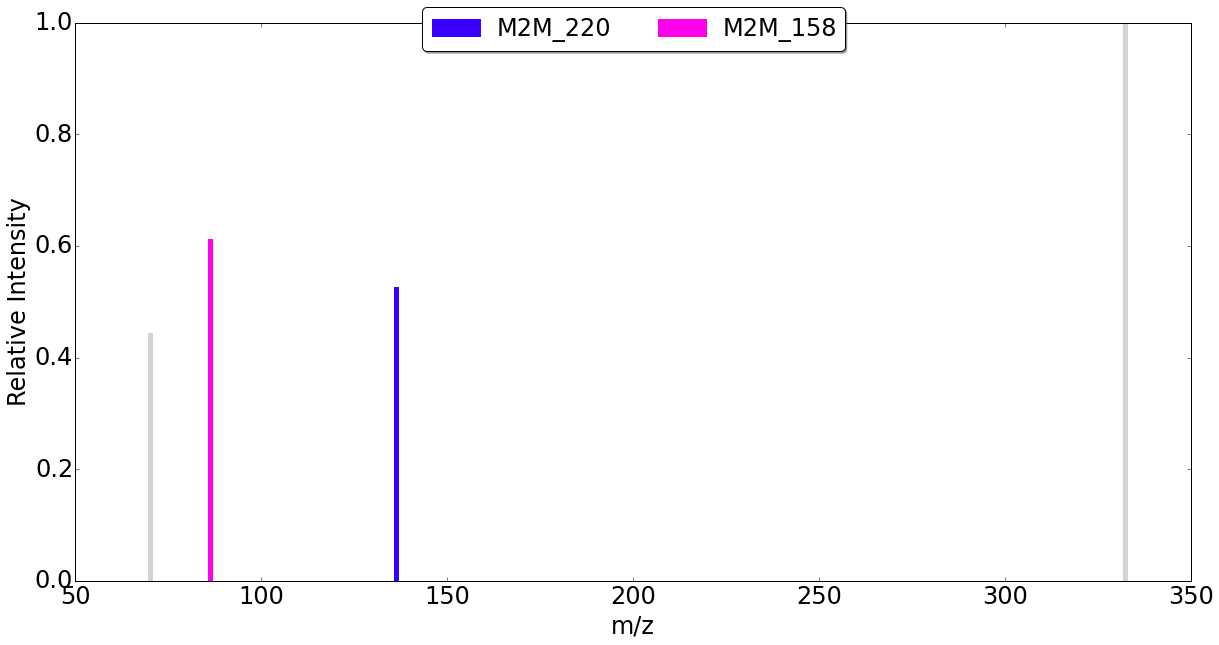

MS1 peakID 23497 mz 300.0844 rt 370.65 intensity 1123364.25 (C20H14NS) degree 3
 - M2M_220	: Adenine substructure
 - M2M_158	: Leucine related substructure
 - M2M_55	: Cinnamic acid (cinnamate) substructure



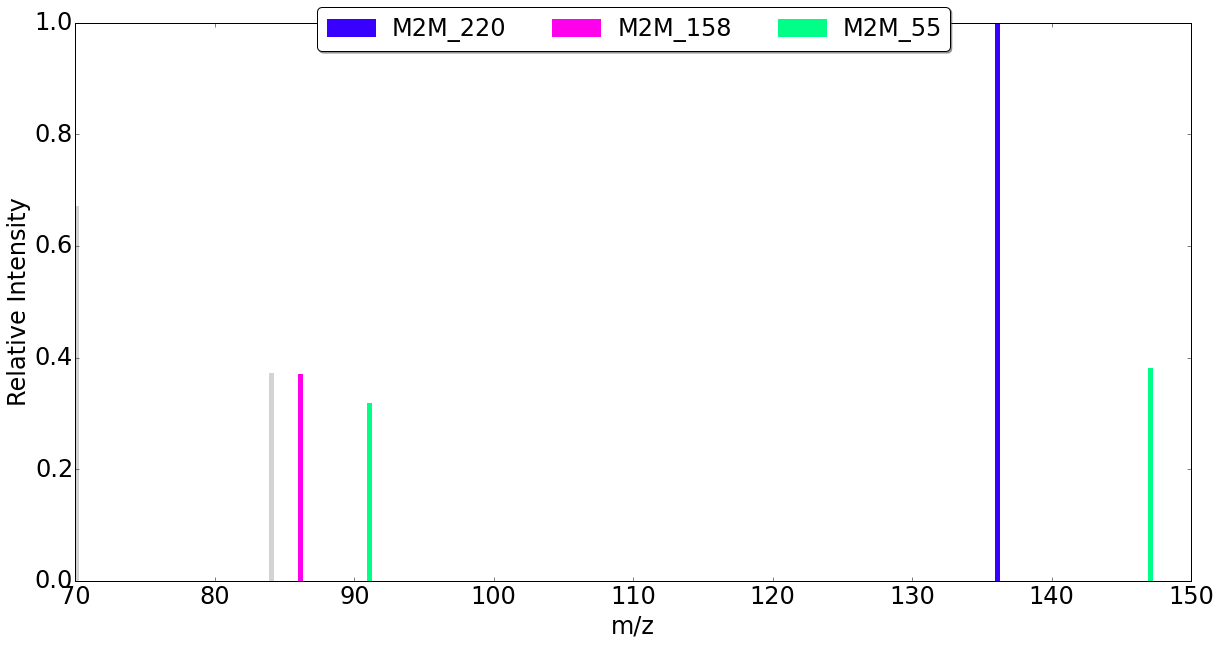

MS1 peakID 6001 mz 166.0863 rt 499.24 intensity 15979306.00 (C9H12O2N) degree 2
 - M2M_115	: [phenylalanine-COOH] based substructure
 - M2M_262	: Carboxylic acid group (COOH) - generic substructure in amino acids and organic acids



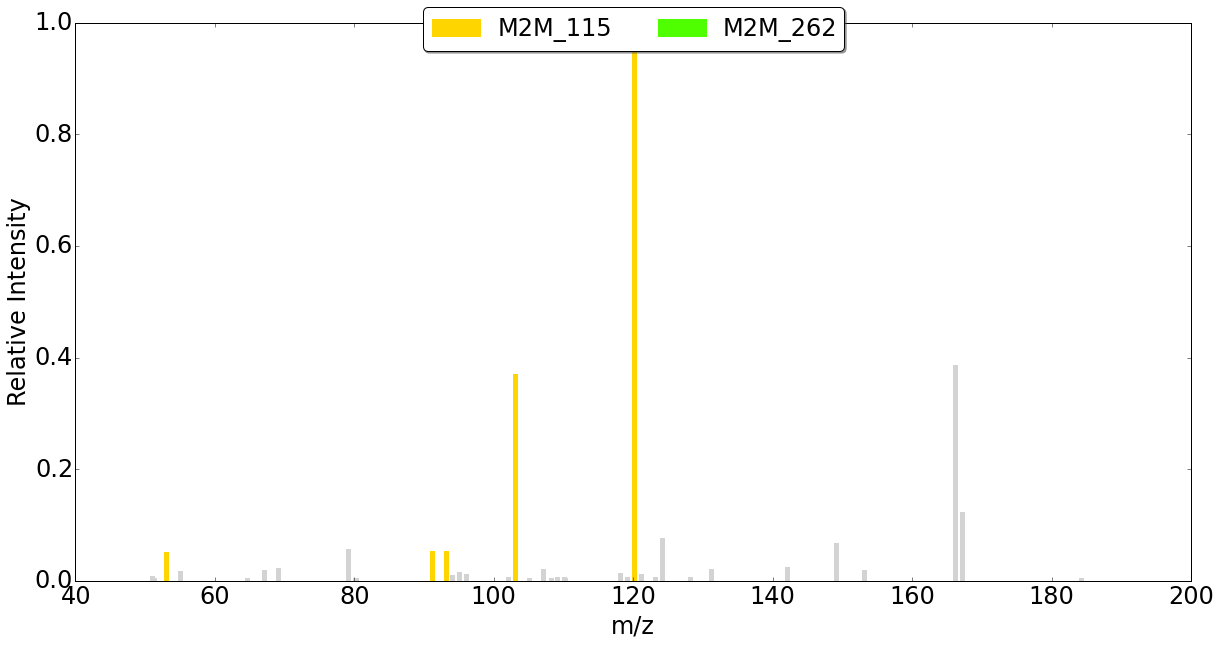

MS1 peakID 4779 mz 156.0768 rt 621.07 intensity 110043960.00 (C6H10O2N3) degree 2
 - M2M_241	: Histidine substructure
 - M2M_262	: Carboxylic acid group (COOH) - generic substructure in amino acids and organic acids



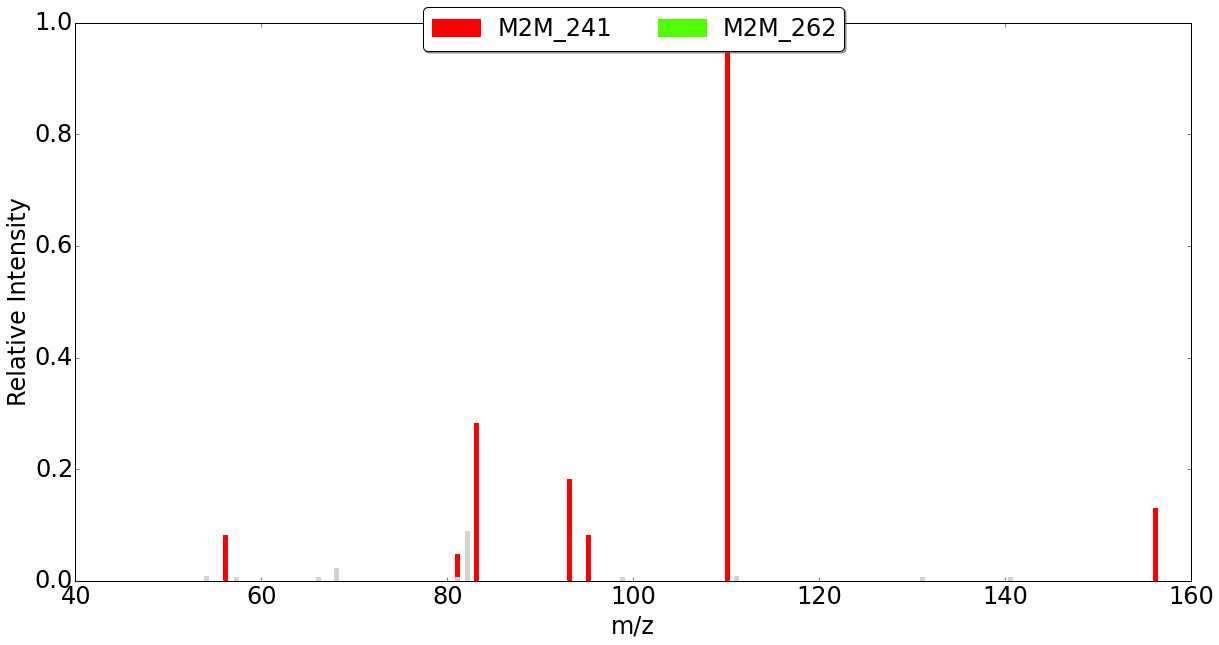

MS1 peakID 20222 mz 277.1474 rt 435.83 intensity 520255.16 (C13H25O4S) degree 3
 - M2M_241	: Histidine substructure
 - M2M_202	: Tryptophan related substructure
 - M2M_158	: Leucine related substructure



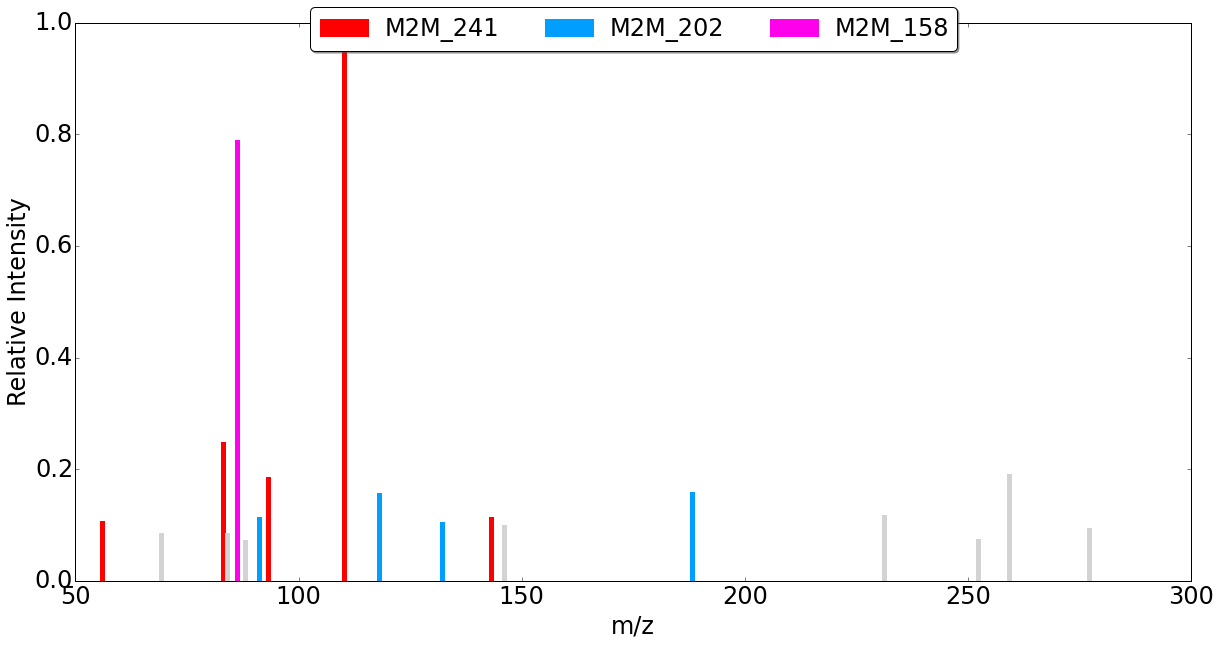

MS1 peakID 2218 mz 132.0541 rt 484.00 intensity 1776054.25 (nan) degree 2
 - M2M_158	: Leucine related substructure
 - M2M_262	: Carboxylic acid group (COOH) - generic substructure in amino acids and organic acids



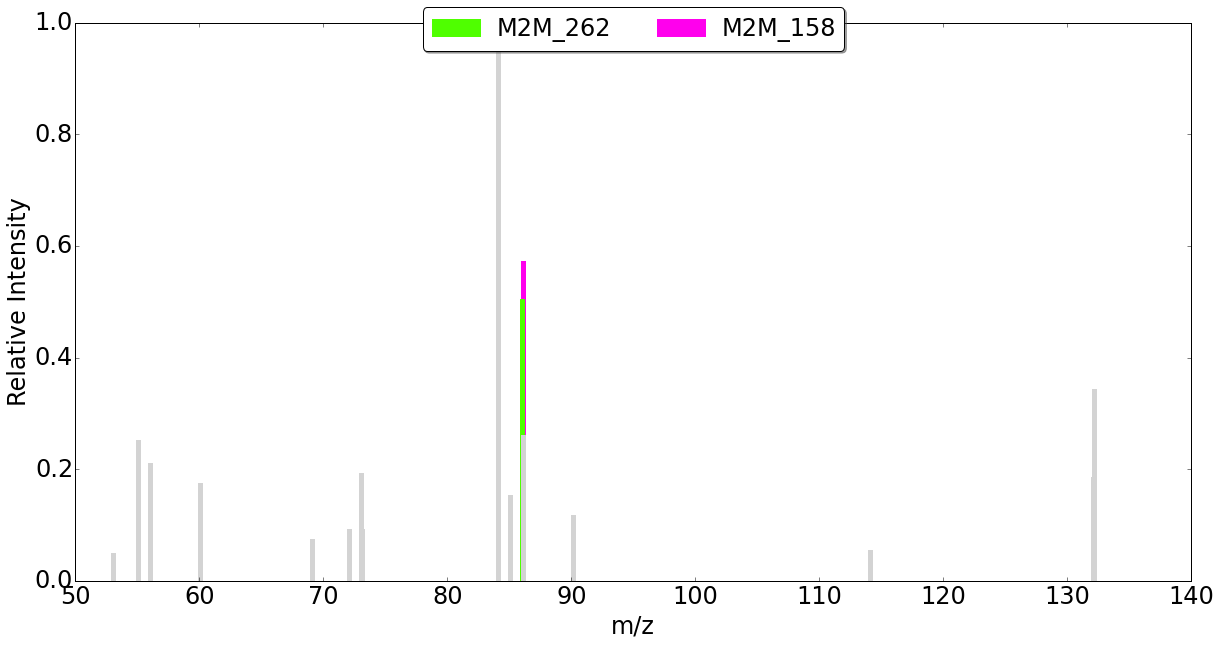

MS1 peakID 28706 mz 362.2166 rt 503.15 intensity 643910.00 (C21H34NP2) degree 2
 - M2M_241	: Histidine substructure
 - M2M_158	: Leucine related substructure



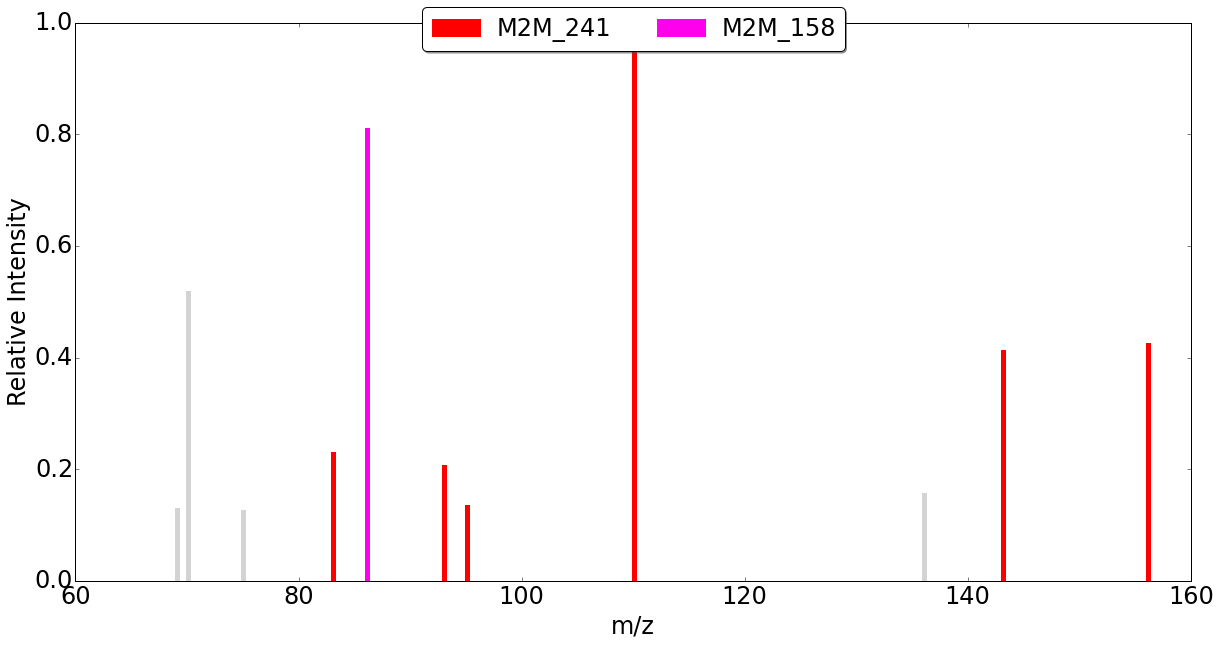

MS1 peakID 23504 mz 300.0844 rt 381.02 intensity 1712000.25 (C20H14NS) degree 3
 - M2M_220	: Adenine substructure
 - M2M_158	: Leucine related substructure
 - M2M_55	: Cinnamic acid (cinnamate) substructure



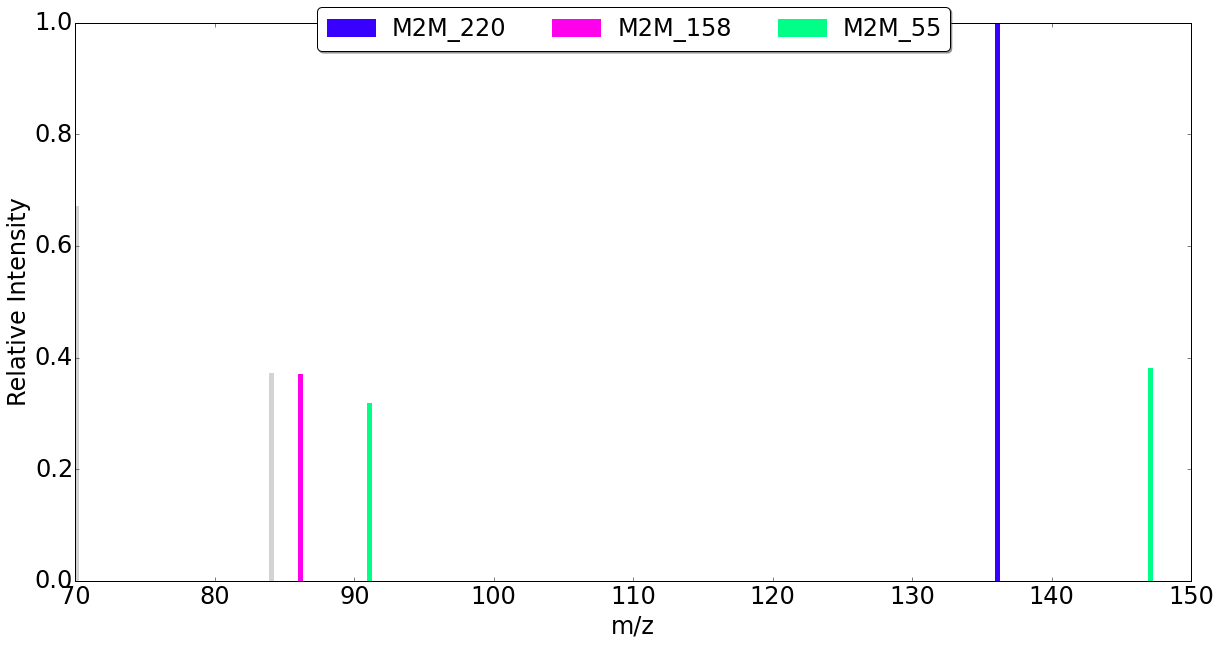

MS1 peakID 20242 mz 277.1582 rt 304.98 intensity 1053594.50 (C14H22N4P) degree 3
 - M2M_241	: Histidine substructure
 - M2M_115	: [phenylalanine-COOH] based substructure
 - M2M_158	: Leucine related substructure



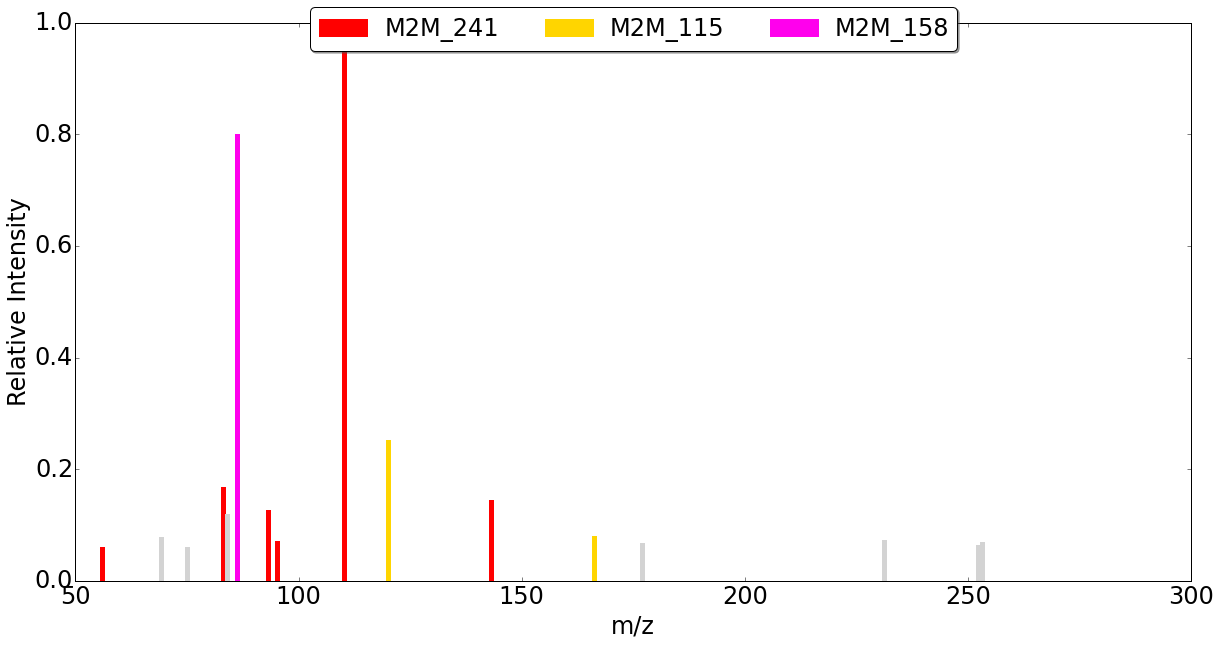

MS1 peakID 2403 mz 132.1019 rt 519.74 intensity 28418200.00 (C6H14O2N) degree 2
 - M2M_158	: Leucine related substructure
 - M2M_262	: Carboxylic acid group (COOH) - generic substructure in amino acids and organic acids



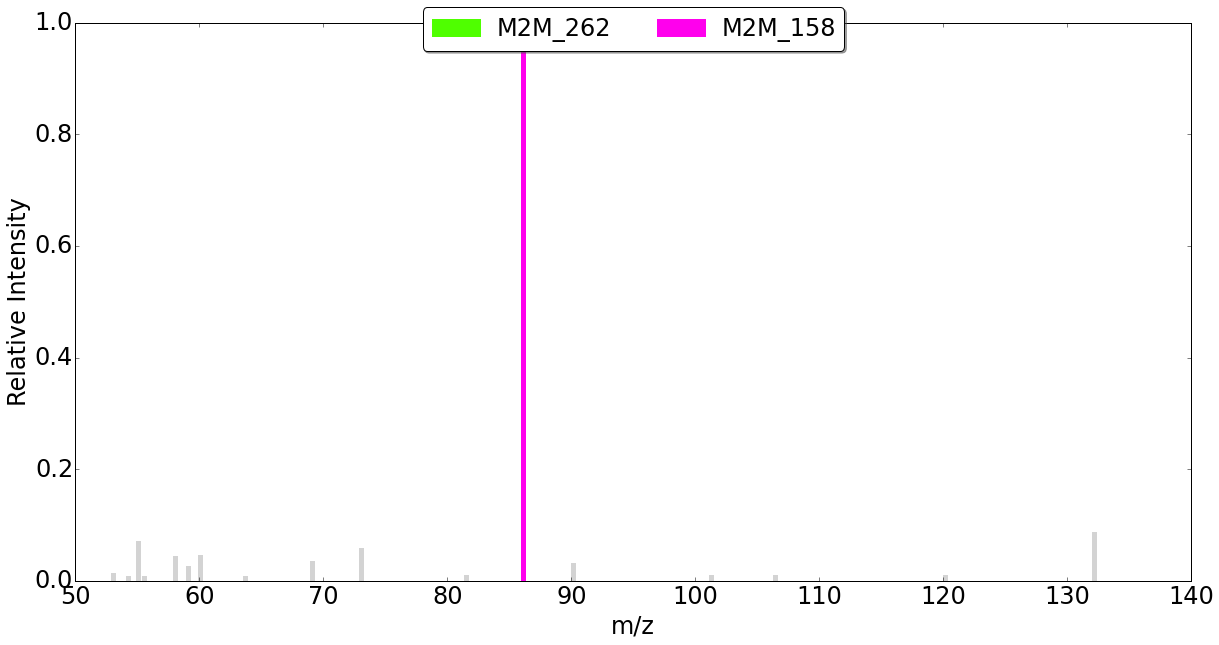

MS1 peakID 26183 mz 332.1106 rt 448.38 intensity 1373344.50 (C13H22O3N3S2) degree 2
 - M2M_220	: Adenine substructure
 - M2M_158	: Leucine related substructure



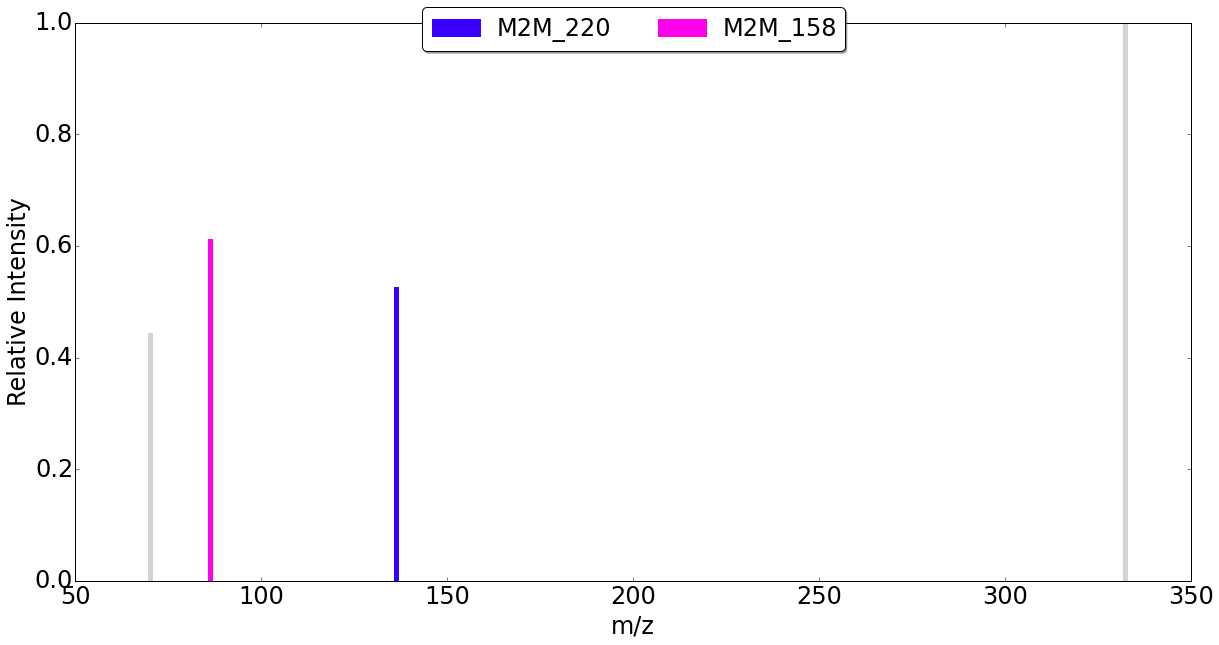

MS1 peakID 25197 mz 318.0951 rt 500.48 intensity 764841.75 (C20H16ONS) degree 2
 - M2M_220	: Adenine substructure
 - M2M_158	: Leucine related substructure



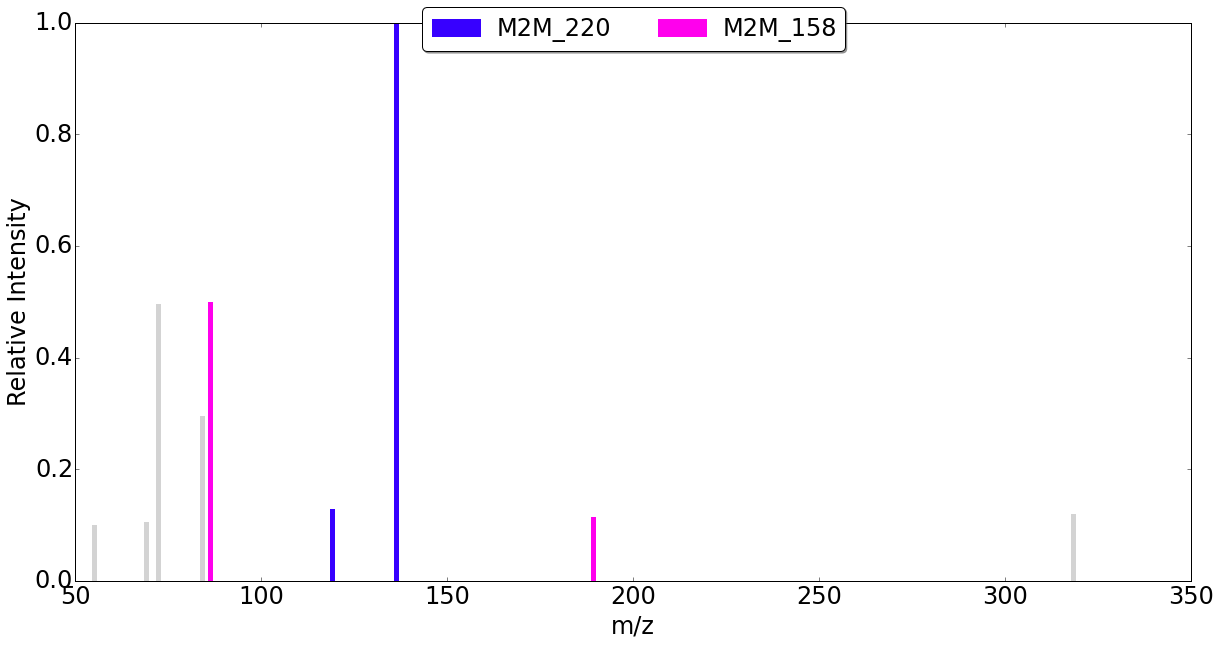

MS1 peakID 33939 mz 553.3097 rt 304.98 intensity 624766.81 (nan) degree 2
 - M2M_241	: Histidine substructure
 - M2M_158	: Leucine related substructure



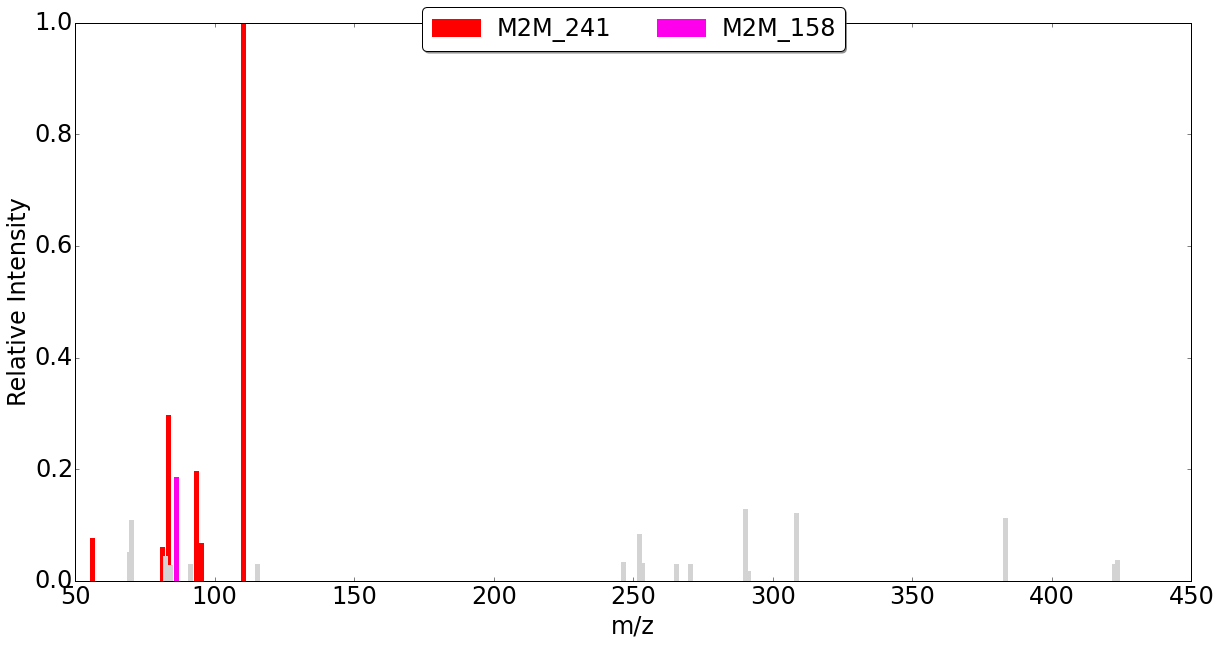

MS1 peakID 17896 mz 261.0943 rt 508.42 intensity 1623367.88 (C7H13O5N6) degree 2
 - M2M_202	: Tryptophan related substructure
 - M2M_158	: Leucine related substructure



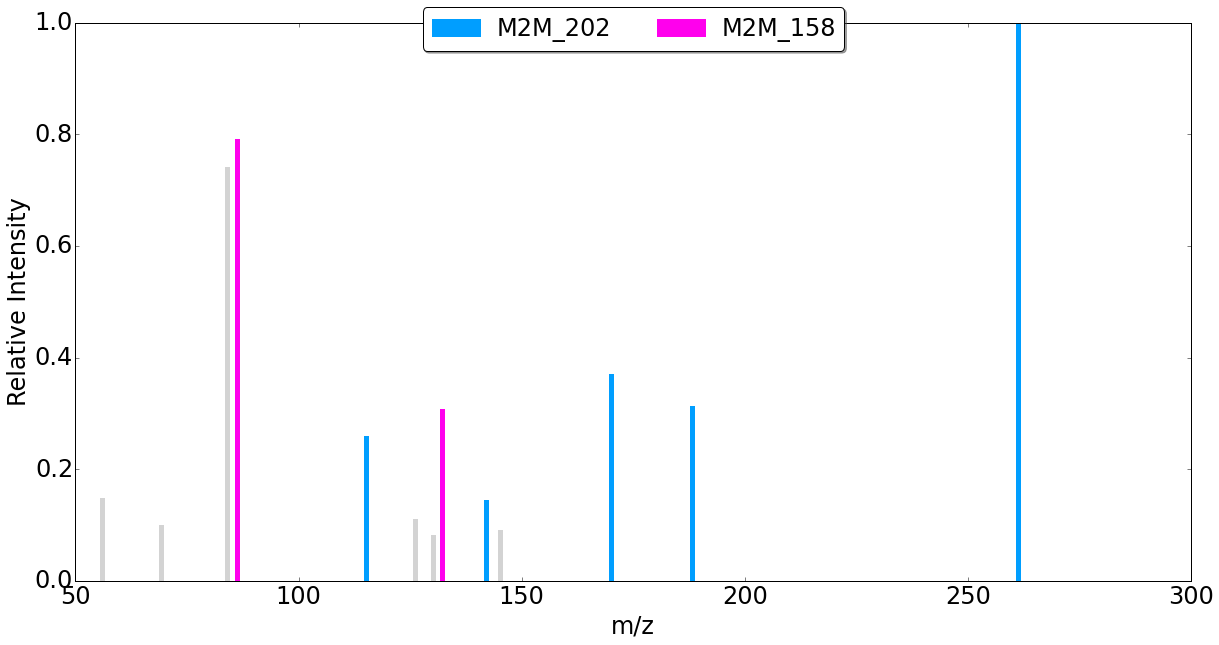

MS1 peakID 2423 mz 132.1020 rt 533.57 intensity 6341282.50 (C6H14O2N) degree 2
 - M2M_158	: Leucine related substructure
 - M2M_262	: Carboxylic acid group (COOH) - generic substructure in amino acids and organic acids



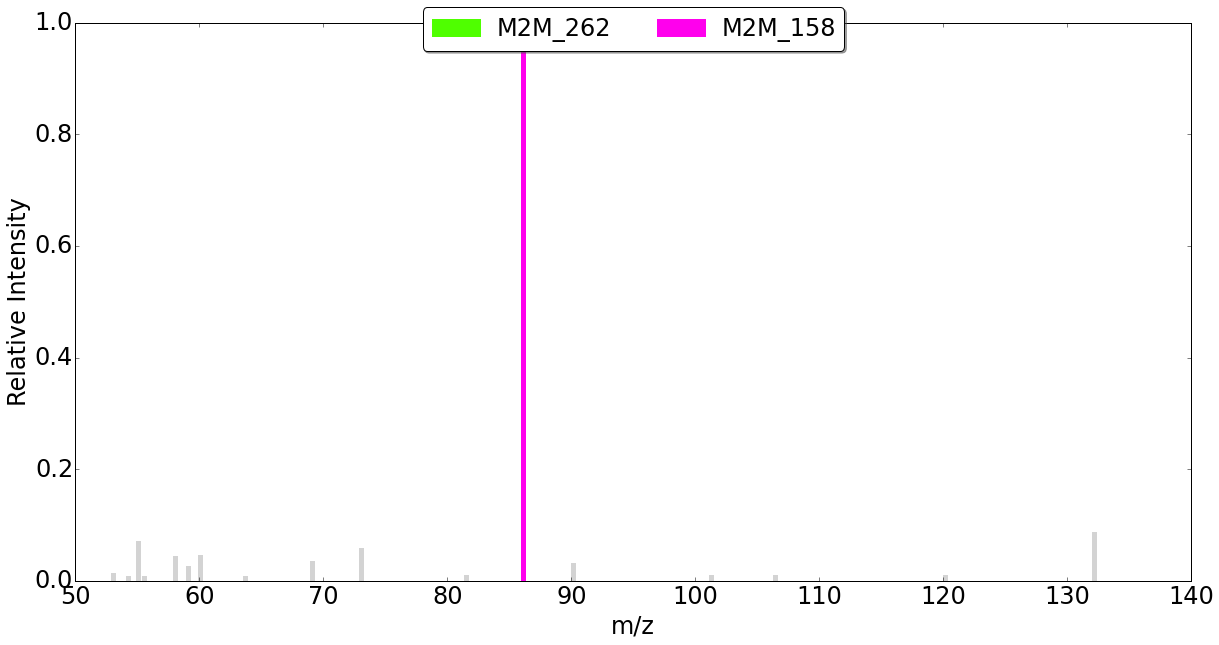

MS1 peakID 23511 mz 300.0845 rt 387.90 intensity 2229831.25 (C20H14NS) degree 3
 - M2M_220	: Adenine substructure
 - M2M_158	: Leucine related substructure
 - M2M_55	: Cinnamic acid (cinnamate) substructure



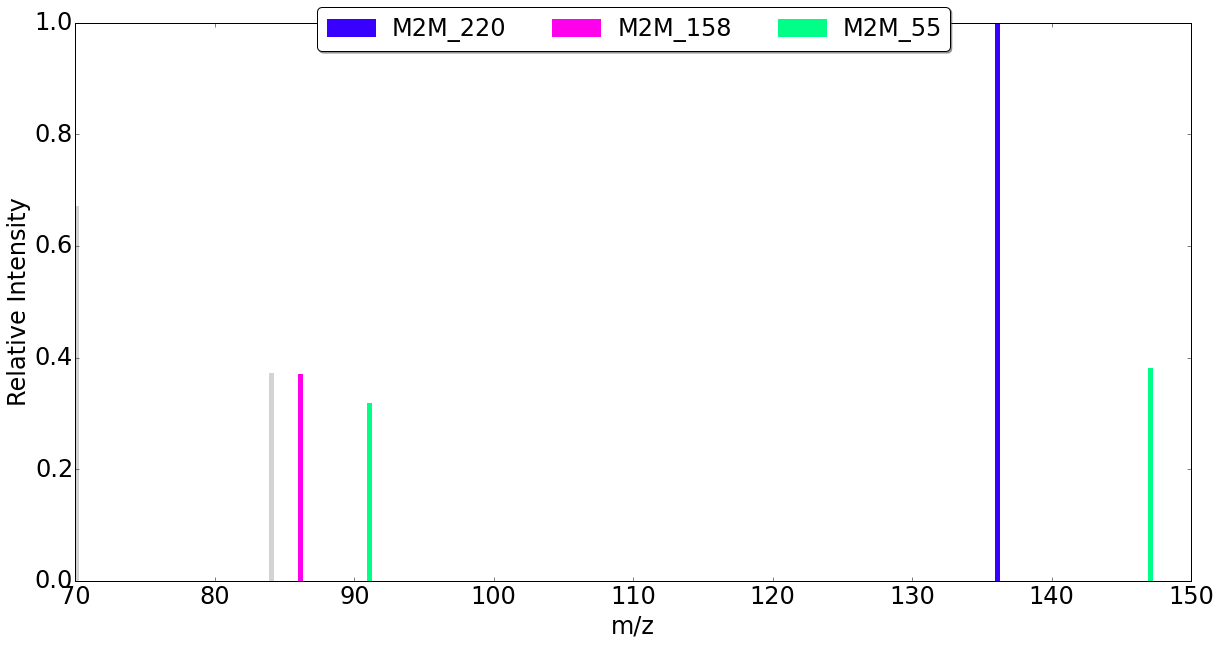

MS1 peakID 12354 mz 222.1124 rt 287.88 intensity 3876743.25 (C12H16O3N) degree 2
 - M2M_202	: Tryptophan related substructure
 - M2M_262	: Carboxylic acid group (COOH) - generic substructure in amino acids and organic acids



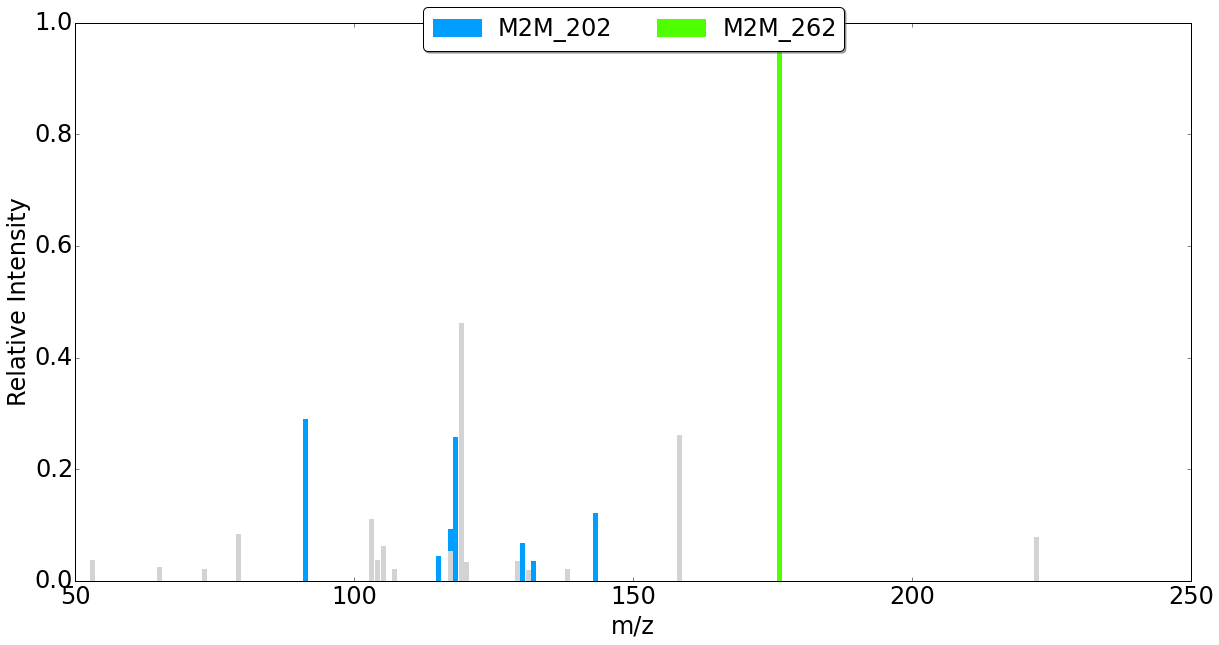

MS1 peakID 10254 mz 204.1232 rt 361.96 intensity 530557.62 (C9H18O4N) degree 2
 - M2M_220	: Adenine substructure
 - M2M_262	: Carboxylic acid group (COOH) - generic substructure in amino acids and organic acids



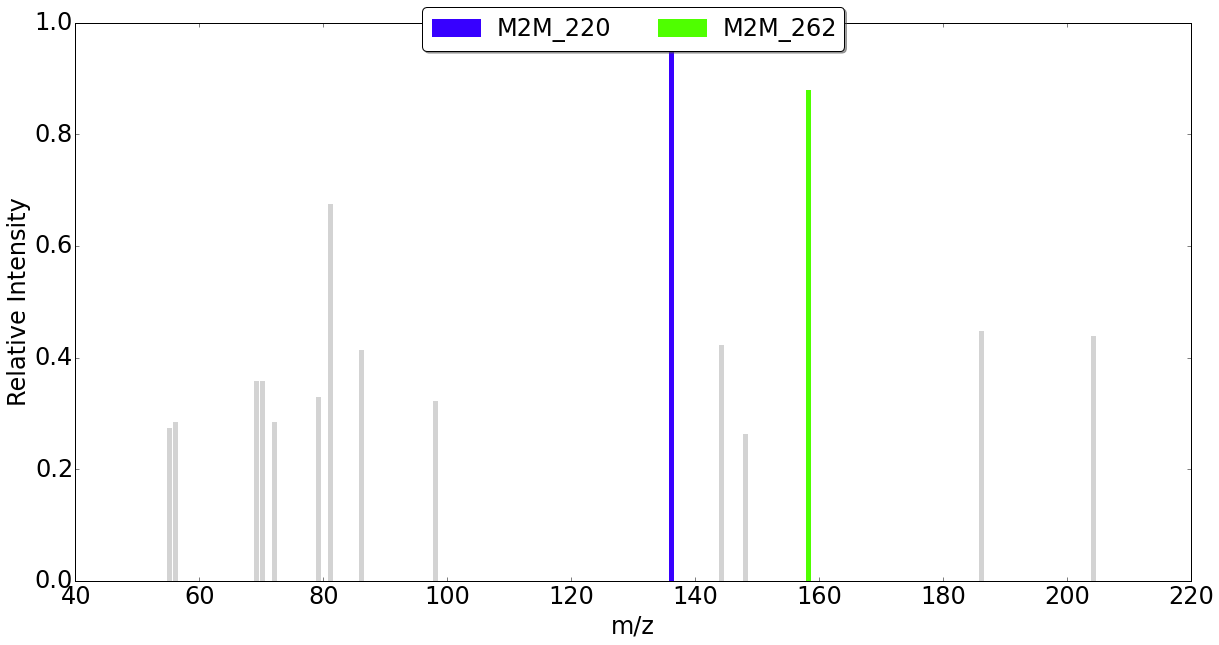

MS1 peakID 4864 mz 157.0801 rt 621.07 intensity 7317130.00 (C5H10O2N3[C13]) degree 2
 - M2M_241	: Histidine substructure
 - M2M_262	: Carboxylic acid group (COOH) - generic substructure in amino acids and organic acids



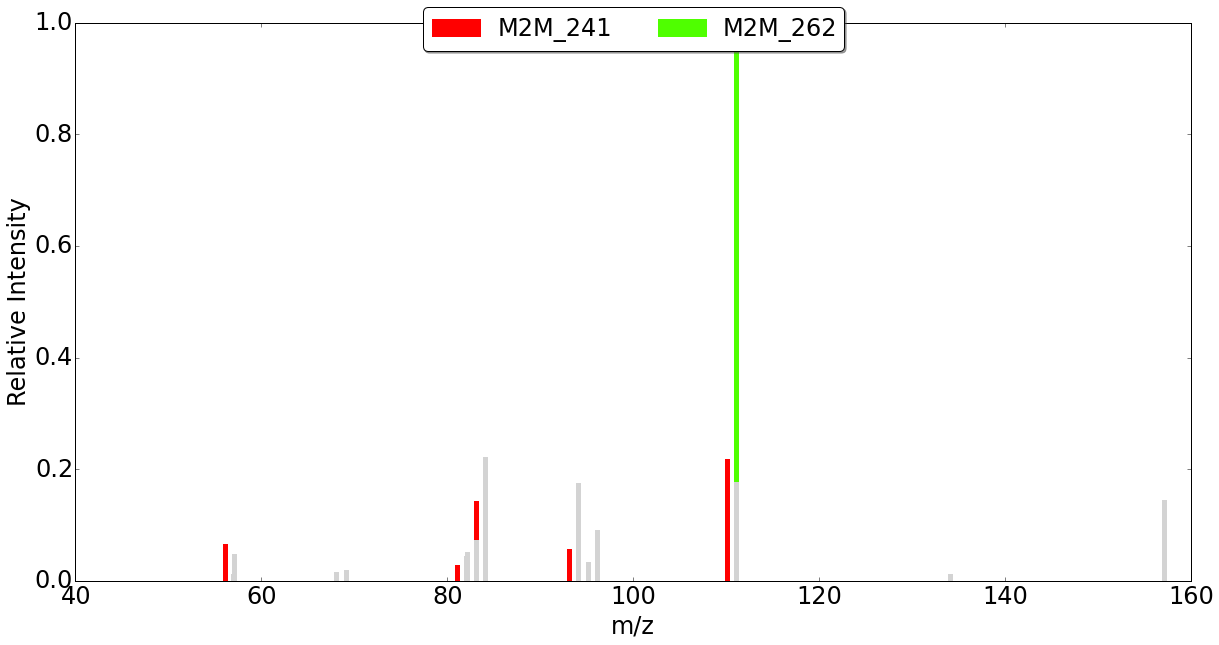

MS1 peakID 11985 mz 218.0811 rt 278.95 intensity 1742296.00 (C12H12O3N) degree 2
 - M2M_202	: Tryptophan related substructure
 - M2M_262	: Carboxylic acid group (COOH) - generic substructure in amino acids and organic acids



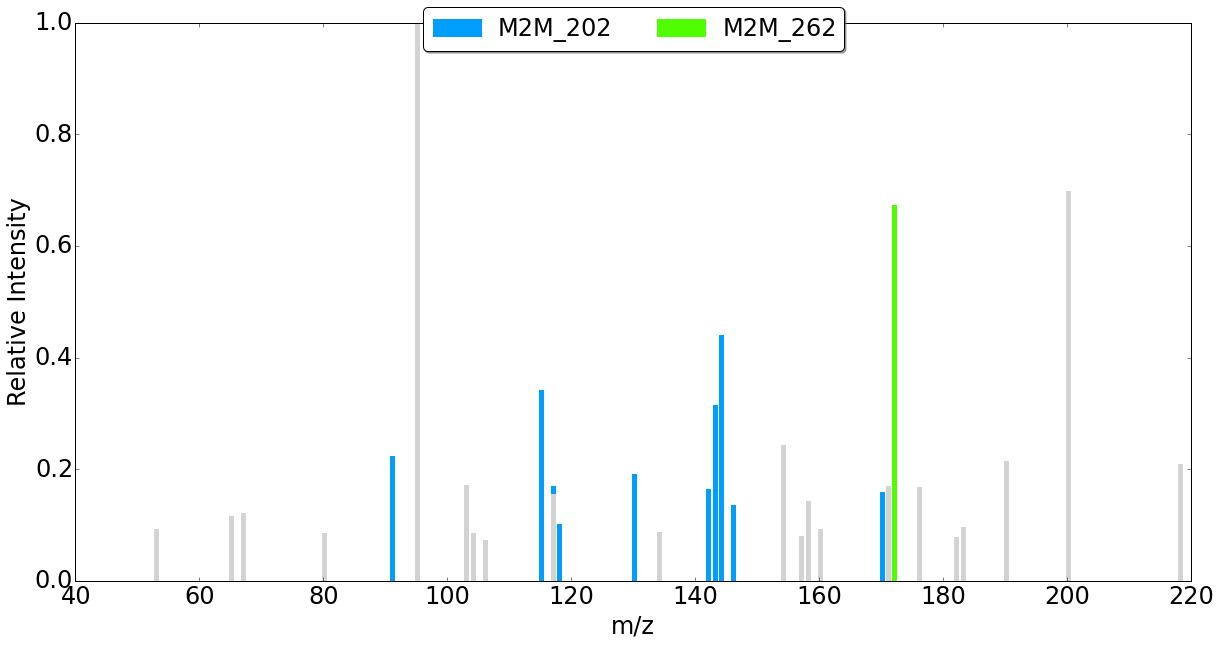

MS1 peakID 33091 mz 471.2238 rt 295.71 intensity 579686.94 (nan) degree 2
 - M2M_115	: [phenylalanine-COOH] based substructure
 - M2M_158	: Leucine related substructure



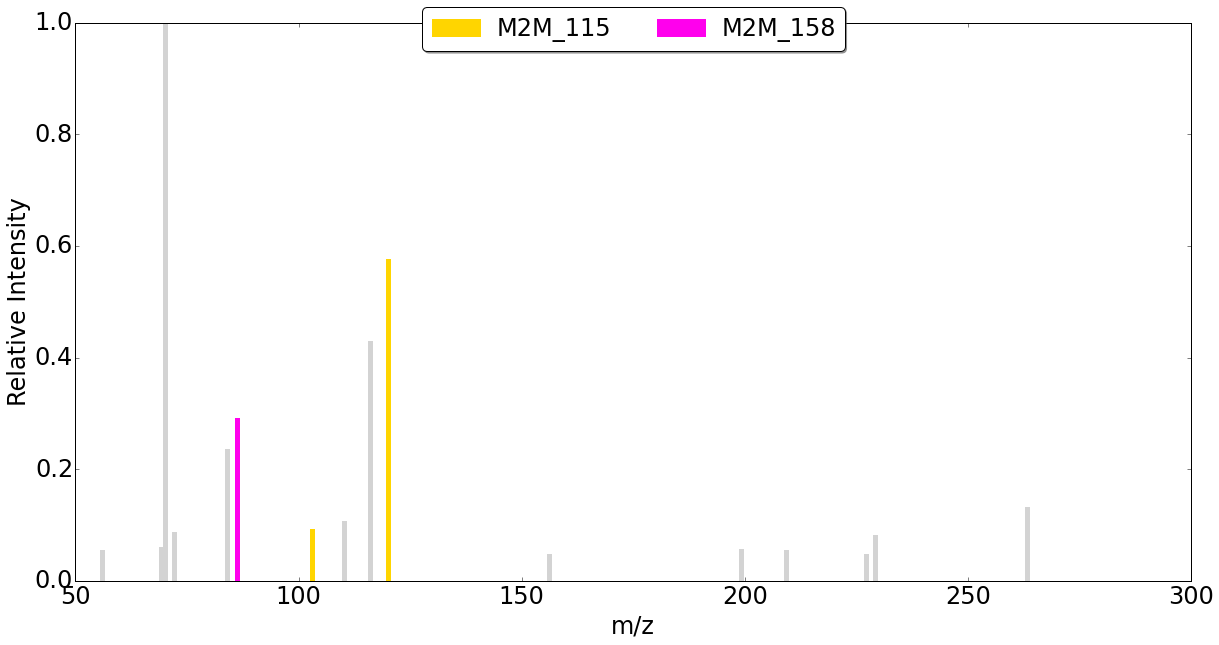

In [119]:
# print all the nodes of interest in the bipartite graph
for node_id in doc_nodes:
    peak_id = int(G.node[node_id]['peakid'])    
    print_report(G, peak_id, doc_motifs)